In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from math import nan
import pandas as pd

from CASutils import mapplot_utils as mymaps
from CASutils import calendar_utils as cal
from CASutils import averaging_utils as avg
from CASutils import readdata_utils as read
from CASutils import bootstrap_utils as boot
from CASutils import colorbar_utils as cbars
import sys

import dask
dask.config.set(**{'array.slicing.split_large_chunks': False})
import importlib
importlib.reload(mymaps)

<module 'CASutils.mapplot_utils' from '/home/islas/python/CASanalysis/CASutils/mapplot_utils.py'>

In [2]:
plotpath="/project/cas/islas/python_plots/CAM7_vertres_paper/FIGURES/SUPP/"

In [3]:
era5_tem = xr.open_mfdataset("/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/TEMdiags/mon/ERA5.nc")
l83_omega500 = xr.open_mfdataset("/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/MJO_OMEGA500/MJO_OMEGA500_FL83*.nc", concat_dim='M', combine='nested')
l83_olr = xr.open_mfdataset("/project/cas/islas/python_savs/CAM7_vertres_paper/DATA_SORT/MJO_OLR/MJO_OLR_FL83_1979_2020*.nc", concat_dim='M', combine='nested')

In [4]:
obs_sst = xr.open_mfdataset("/project/mojave/observations/OBS-SST/ersstv5.185401-202412.nc", decode_times=False)
time = pd.date_range("1854-01-01","2024-12-31", freq='MS') + pd.Timedelta(days=14)
obs_sst['time'] = time
obs_sst = cal.season_ts(obs_sst.sst).sel(season='DJF')
obs_sst = obs_sst.sel(year=slice(1980,2020))

In [5]:
basepath="/project/cas/islas/python_savs/CAM7_vertres_paper/RAW_DATA/"
l83_sst=[]
for imem in np.arange(0,3,1):
    memstr = str(imem+1).zfill(3)
    hist = xr.open_dataset(basepath+"L83_FHIST_BGC/"+memstr+"/month_1/f.e21.FHIST_BGC.f09_f09_mg17.L83_cam6."+memstr+".cam.h0.SST.197901-201412.nc")
    hist = read.fixcesmtime(hist)
    ssp = xr.open_dataset(basepath+"L83_FHIST_SSP/"+memstr+"/month_1/f.e21.FHIST_BGC.f09_f09_mg17.L83_cam6_SSP370."+memstr+".cam.h0.SST.201501-202012.nc")
    ssp = read.fixcesmtime(ssp)
    dat = xr.concat([hist, ssp], dim='time')
    l83_sst.append(dat)
l83_sst = xr.concat(l83_sst, dim='M')

/home/islas/python/CASanalysis/CASutils/readdata_utils.py:29: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by converting the values to nanosecond precision ahead of time.
  dat['time'] = timebndavg
/home/islas/python/CASanalysis/CASutils/readdata_utils.py:29: UserWarning: Converting non-nanosecond precision datetime values to nanosecond precision. This behavior can eventually be relaxed in xarray, as it is an artifact from pandas which is now beginning to support non-nanosecond precision values. This warning is caused by passing non-nanosecond np.datetime64 or np.timedelta64 values to the DataArray or Variable constructor; it can be silenced by co

In [6]:
l83_sst_djf = cal.season_ts(l83_sst.SST).sel(season='DJF')

In [7]:
l83_sst_djf_m = l83_sst_djf.mean(['year','M'])

In [8]:
era5_u_djf = cal.season_ts(era5_tem.uzm).sel(season='DJF')
era5_u_djf['plev'] = era5_u_djf.plev / 100.

In [9]:
era5_qbo = avg.cosweightlat(era5_u_djf, -5, 5)
era5_qbo = era5_qbo.interp(plev=50.)

DataArrayWeighted with weights along dimensions: lat


In [10]:
l83_omega500 = l83_omega500.MJO_OMEGA500.std('time')
l83_olr = l83_olr.MJO_OLR.std('time')

In [11]:
era5_qbo = era5_qbo.sel(year=slice(1980,2020))
l83_omega500 = l83_omega500.sel(year=slice(1980,2020))
l83_olr = l83_olr.sel(year=slice(1980,2020))
l83_sst_djf = l83_sst_djf.sel(year=slice(1980,2020))

In [12]:
def composite_w_e(qbo, olr, omega, sst, timevar='year'):
    qbo = qbo - qbo.mean(timevar)
    olr = olr - olr.mean(timevar)
    omega = omega - omega.mean(timevar)
    sst = sst - sst.mean(timevar)
    
    def compute_signif(w, e):
        
        try:
            nmems = w.M.size
            multimem=True
        except:
            multimem=False
        
        if (multimem == True):        
            allevals=[] ; allwvals=[]
            for imem in np.arange(0,w.M.size,1):
                wvals = w.isel(M=imem)
                wvals = wvals.dropna(dim=timevar)
                allwvals.append(wvals)
                evals = e.isel(M=imem)
                evals = evals.dropna(dim=timevar)
                evals = evals.dropna(dim=timevar)
                allevals.append(evals)        
            allevals = xr.concat(allevals, dim='year')
            allwvals = xr.concat(allwvals, dim='year')
        else:
            allevals = e.dropna(dim=timevar)
            allevals = w.dropna(dim=timevar)
            
        signif = boot.bootdif2means(allevals, allwvals)
        return signif
    
    qbo_w = qbo.where( qbo > 0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('u_w')
    qbo_e = qbo.where( qbo < -0.5*qbo.std(timevar), nan).mean(timevar, skipna=True).rename('u_e')
    
    olr_w = olr.where( qbo > 0.5*qbo.std(timevar), nan)
    olr_e = olr.where( qbo < -0.5*qbo.std(timevar), nan)
    signif_olr = compute_signif(olr_w, olr_e)
    signif_olr = signif_olr.rename('signif_olr')
    olr_w = olr_w.mean(timevar, skipna=True).rename('olr_w')
    olr_e = olr_e.mean(timevar, skipna=True).rename('olr_e')
    
    
    omega_w = omega.where( qbo > 0.5*qbo.std(timevar), nan)
    omega_e = omega.where( qbo < -0.5*qbo.std(timevar), nan)
    signif_omega = compute_signif(omega_w, omega_e)
    signif_omega = signif_omega.rename('signif_omega')
    omega_w = omega_w.mean(timevar, skipna=True).rename('omega_w')
    omega_e = omega_e.mean(timevar, skipna=True).rename('omega_e')
    
    sst_w = sst.where( qbo > 0.5*qbo.std(timevar), nan)
    sst_e = sst.where( qbo < -0.5*qbo.std(timevar), nan)
    signif_sst = compute_signif(sst_w, sst_e)
    signif_sst = signif_sst.rename('signif_sst')
    sst_w = sst_w.mean(timevar, skipna=True).rename('sst_w')
    sst_e = sst_e.mean(timevar, skipna=True).rename('sst_e')
    
    datout = xr.merge([qbo_w, qbo_e, olr_w, olr_e, omega_w, omega_e, sst_w, sst_e,
                      signif_olr, signif_omega, signif_sst])
    
    return datout

In [13]:
composite = composite_w_e(era5_qbo, l83_olr, l83_omega500, l83_sst_djf)
#composite_obs = composite_w_e(era5_qbo, obs_sst, obs_sst, obs_sst)

[1000, 39]
you are using an xarray dataarray
[1000, 54]
you are using an xarray dataarray
[1000, 39]
you are using an xarray dataarray
[1000, 54]
you are using an xarray dataarray
[1000, 39]
you are using an xarray dataarray
[1000, 54]
you are using an xarray dataarray


In [14]:
composite_em = composite.mean('M')

In [15]:
composite_em = composite_em.load()

[-2.  -1.8 -1.6 -1.4 -1.2 -1.  -0.8 -0.6 -0.4  0.4  0.6  0.8  1.   1.2
  1.4  1.6  1.8  2. ]
[-7. -6. -5. -4. -3. -2.  2.  3.  4.  5.  6.  7.]
[-0.022 -0.02  -0.018 -0.016 -0.014 -0.012 -0.01  -0.008 -0.006 -0.004
  0.004  0.006  0.008  0.01   0.012  0.014  0.016  0.018  0.02   0.022]


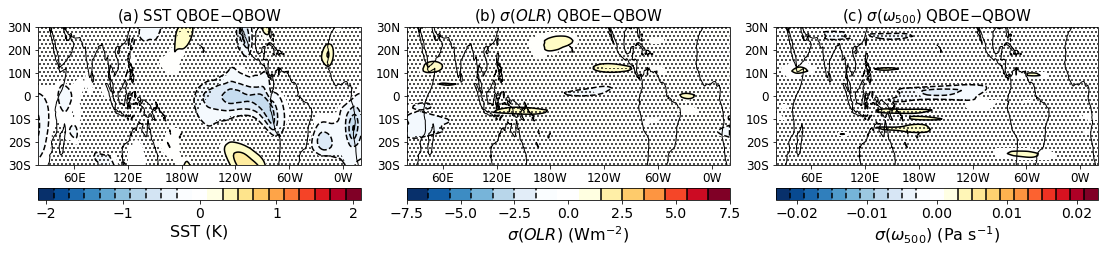

In [16]:
fig = plt.figure(figsize=(16,16))

ci = 0.2 ; cmax = 2

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, composite_em.sst_e - composite_em.sst_w, composite_em.lon, composite_em.lat,
                                                   ci, -1.*cmax, cmax, '(a) SST QBOE$-$QBOW',
                                                   0.02,0.3,0.85,0.97, contourlines=True, signifdat = composite_em.signif_sst, stipplesignif=True )
ax = cbars.plotcolorbar(fig, ci, -1.*cmax, cmax,'SST (K)',0.02,0.3,0.82,0.83, contourlines=True)


ci = 1 ; cmax=7

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, composite_em.olr_e - composite_em.olr_w, composite_em.lon, composite_em.lat,
                                                   ci, -1.*cmax, cmax, '(b) $\sigma(OLR)$ QBOE$-$QBOW',
                                                   0.34,0.62,0.85,0.97, contourlines=True, signifdat = composite_em.signif_olr, stipplesignif=True )
ax = cbars.plotcolorbar(fig, ci, -1.*cmax, cmax, '$\sigma(OLR)$ (Wm$^{-2}$)',0.34,0.62,0.82,0.83, contourlines=True)

ci = 0.002 ; cmax = 0.022

ax = mymaps.contourmap_bothoceans_tropics_fill_pos(fig, composite_em.omega_e - composite_em.omega_w, composite_em.lon, composite_em.lat,
                                                   ci, -1.*cmax, cmax, '(c) $\sigma(\omega_{500})$ QBOE$-$QBOW',
                                                   0.66,0.94,0.85,0.97, contourlines=True, signifdat = composite_em.signif_omega, stipplesignif=True )
ax = cbars.plotcolorbar(fig, ci, -1.*cmax, cmax, '$\sigma(\omega_{500})$ (Pa s$^{-1}$)',
                        0.66,0.94,0.82,0.83, contourlines=True)

fig.savefig(plotpath+'figS11.pdf', bbox_inches='tight', facecolor='white')